### Project Title: 
##### Time Series Analysis: "Demand Forecasting for Inventory Optimization at Corporation Favorita"


### 1. Business Understanding
#### Business Scenario
As data scientists in Corporation Favorita, a large Ecuadorian-based grocery retailer, we are tasked to ensure that there is always the right quantity of products in stock.
To do this we have decided to build a series of machine learning models to forecast the demand of products in various locations.We have been provided with some datasets to help in this project.



#### Project Description
This project aims to ensure optimal inventory levels at Corporation Favorita, by leveraging machine learning models to forecast product demand across various locations. Accurate demand forecasting will help maintain the right quantity of products in stock, reducing instances of overstocking and stockouts, thereby enhancing customer satisfaction and minimizing operational costs. The project follows the CRISP-DM framework and utilizes data provided by the marketing and sales teams to develop and validate predictive models


#### Business Objective
The primary objective of this project is to develop and implement a series of machine learning models to accurately forecast the demand for various products across different locations of Corporation Favorita. By achieving this objective, Corporation Favorita aims to optimize its inventory management, ensuring that the right quantity of products is consistently in stock. 



#### Hypothesis Testing
Null Hypothesis (H0): Promotional activities do not have a significant impact on sales



Alternate Hypothesis (H1): Promotional activities have a significant impact on sales
 

#### Analytical Questions
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

### 2. Data Understanding
#### Sourcing the Dataset
The datasets were sourced from a github repository, a onedrive account, and a SQL server database.

The data at a github repository contains two dattasets; train and transactions

The data at a onedrive  was downloaded manually due to permission issues and contains two datasets also. This is to be used for testing purposes.

The datasets hosted by a SQL server database was queried, and the respective dataframes saved as single files in csv format.

In [1]:
### Install required packages
# !pip install statsmodels


#Libraries for sql
# database connections
import pyodbc    
from dotenv import dotenv_values
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ValueWarning

#libraries for handling data
import pandas as pd
import numpy as np

##data visualizations
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import calplot

# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#stat models
# from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import ttest_ind

# Error evaluations
from sklearn.metrics import mean_squared_error, mean_squared_log_error,mean_squared_log_error, mean_absolute_error

# Modelling
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

import joblib

Data from SQL Server database

In [7]:
# #Loading first dataset from database
# Load environment variables from .env file
environment_variables = dotenv_values(".env")

# # Access database credentials from environment variables dictionary
server = environment_variables.get("server")
login = environment_variables.get("login")
password = environment_variables.get("password")
database = environment_variables.get("database")

# # Create the connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"


# Connect to the database
try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful!:", connection_string)
except Exception as e:
    print("Error:", e)

# # Specify the SQL queries to extract data from the tables
# oil_data = "SELECT * FROM dbo.oil"
# holiday_data = "SELECT * FROM dbo.holidays_events"
# store_data = "SELECT * FROM dbo.store"

# # Suppress warnings
# warnings.filterwarnings('ignore')

# # Create a cursor from the connection
# # with connection.cursor() as cursor:
#     # Execute the queries and fetch data into Pandas DataFrames
# oil_data = pd.read_sql_query(oil_data, connection)
# holiday_data = pd.read_sql_query(holiday_data, connection)
# store_data = pd.read_sql_query(store_data, connection)

Error: ('08001', '[08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]SQL Server does not exist or access denied. (17) (SQLDriverConnect); [08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]ConnectionOpen (Connect()). (53)')


In [4]:
holiday_data = pd.read_csv("holiday_data.csv")
holiday_data

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [11]:
stores_data = pd.read_csv("stores_data.csv")
stores_data.head(7)

,Unnamed: 0,store_nbr,city,state,type,cluster
0,0,1,Quito,Pichincha,D,13
1,1,2,Quito,Pichincha,D,13
2,2,3,Quito,Pichincha,D,8
3,3,4,Quito,Pichincha,D,9
4,4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,5,6,Quito,Pichincha,D,13
6,6,7,Quito,Pichincha,D,8


In [12]:
oil_data = pd.read_csv("oil_data.csv")
oil_data

,Unnamed: 0,date,dcoilwtico
0,0,2013-01-01,NaN
1,1,2013-01-02,93.139999
2,2,2013-01-03,92.970001
3,3,2013-01-04,93.120003
4,4,2013-01-07,93.199997
...,...,...,...
1213,1213,2017-08-25,47.650002
1214,1214,2017-08-28,46.400002
1215,1215,2017-08-29,46.459999
1216,1216,2017-08-30,45.959999


Load train data from Github

In [13]:
transactions_data = pd.read_csv("transactions.csv")
transactions_data

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [15]:
train_data = pd.read_csv("train.csv")
train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Load test data from Onedrive 

In [16]:
test_data = pd.read_csv("test.csv")
test_data

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


#### Exploratory Data Analysis (EDA)

The Train Data

In [17]:
# Check for nulls in the train_data 
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [18]:
#Check for duplicates in the train_data

train_data.duplicated().sum()

np.int64(0)

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [20]:
# The date column has the wrong datatype, needs to be converted to datetime

train_data["date"] = pd.to_datetime(train_data["date"])

# Confirm dtype
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [21]:
# date column has correct values now, get all unique values
train_data['date'].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00',
 ...
 '2017-08-06 00:00:00', '2017-08-07 00:00:00', '2017-08-08 00:00:00',
 '2017-08-09 00:00:00', '2017-08-10 00:00:00', '2017-08-11 00:00:00',
 '2017-08-12 00:00:00', '2017-08-13 00:00:00', '2017-08-14 00:00:00',
 '2017-08-15 00:00:00']
Length: 1684, dtype: datetime64[ns]

In [22]:
# see all unique values in store_nbr column
train_data['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [23]:
# see all unique values in family column
train_data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [24]:
#Check statistics of train_data
train_data.describe().T

,count,mean,min,25%,50%,75%,max,std
id,3000888.0,1500443.5,0.0,750221.75,1500443.5,2250665.25,3000887.0,866281.891642
date,3000888,2015-04-24 08:27:04.703088384,2013-01-01 00:00:00,2014-02-26 18:00:00,2015-04-24 12:00:00,2016-06-19 06:00:00,2017-08-15 00:00:00,NaN
store_nbr,3000888.0,27.5,1.0,14.0,27.5,41.0,54.0,15.585787
sales,3000888.0,357.775749,0.0,0.0,11.0,195.84725,124717.0,1101.997721
onpromotion,3000888.0,2.60277,0.0,0.0,0.0,0.0,741.0,12.218882


#### Observation:
* The id variable ranges from 0 to 3,000,887, with a uniform distribution around the mean value of 1,500,444.
* The store_nbr variable ranges from 1 to 54, suggesting there are 54 stores represented in the data.
* The sales variable has a wide range (0 to 124,717) with a high standard deviation, indicating significant variability in sales amounts.
* The onpromotion variable also has a wide range (0 to 741) but a median and 75th percentile of 0, indicating that the majority of entries have no promotions, with a few having a large number of promotions.

In [25]:
#Sorting the index
train_data = train_data.sort_index(ascending=True)

The transactions data

In [27]:
#Check dataset
transactions_data.head(7)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143


In [28]:
#Check info
transactions_data.info()

#  date has wrong dtype in transactions


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [29]:
#Convert the date column to datetime
transactions_data["date"] = pd.to_datetime(transactions_data["date"])

# Confirm change
transactions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [30]:
#Check for null values
transactions_data.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [31]:
#Check for duplicates
transactions_data.duplicated().sum()

np.int64(0)

The Oil Data

In [32]:
#Check dataset
oil_data.head()

,Unnamed: 0,date,dcoilwtico
0,0,2013-01-01,NaN
1,1,2013-01-02,93.139999
2,2,2013-01-03,92.970001
3,3,2013-01-04,93.120003
4,4,2013-01-07,93.199997


In [33]:
#Check cell values
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1218 non-null   int64  
 1   date        1218 non-null   object 
 2   dcoilwtico  1175 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 28.7+ KB


Observation: 
* The date column has the wrong datatype, this needs to be corrected.
* There is also an unnamed column in the dataset. This will be removed after confirming it unique values

In [34]:
#Convert the date column to datetime
oil_data["date"] = pd.to_datetime(oil_data["date"])

#Confirm change made
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1218 non-null   int64         
 1   date        1218 non-null   datetime64[ns]
 2   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 28.7 KB


In [35]:
#Check for nulls in the oil dataset
oil_data.isnull().sum()

Unnamed: 0     0
date           0
dcoilwtico    43
dtype: int64

dcoilwtico colmun in oil_data has 43 missing values

In [36]:
#  set date as the index column
oil_data.set_index('date', inplace=True)


In [37]:
oil_data.head(7)

,Unnamed: 0,dcoilwtico
date,,
2013-01-01,0,NaN
2013-01-02,1,93.139999
2013-01-03,2,92.970001
2013-01-04,3,93.120003
2013-01-07,4,93.199997
2013-01-08,5,93.209999
2013-01-09,6,93.080002


The Stores Data

In [38]:
#Check dataset
stores_data.head(7)

,Unnamed: 0,store_nbr,city,state,type,cluster
0,0,1,Quito,Pichincha,D,13
1,1,2,Quito,Pichincha,D,13
2,2,3,Quito,Pichincha,D,8
3,3,4,Quito,Pichincha,D,9
4,4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,5,6,Quito,Pichincha,D,13
6,6,7,Quito,Pichincha,D,8


In [39]:
#Checking cell values and dtypes
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  54 non-null     int64 
 1   store_nbr   54 non-null     int64 
 2   city        54 non-null     object
 3   state       54 non-null     object
 4   type        54 non-null     object
 5   cluster     54 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 2.7+ KB


In [40]:
#Check for nulls in the stores_data
stores_data.isnull().sum()

Unnamed: 0    0
store_nbr     0
city          0
state         0
type          0
cluster       0
dtype: int64

In [41]:
#Check for duplicates in the stores dataset
stores_data.duplicated().sum()

np.int64(0)

In [42]:
# see all unique values in store_nbr column 
stores_data['store_nbr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [43]:
# see all unique elements in city column
stores_data['city'].unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [44]:
# see all unique elements in state column
stores_data['state'].unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [46]:
# see all unique elements in type column
stores_data['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [47]:
# see all unique values in cluster column
stores_data['cluster'].unique()

array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17])

The holiday data

In [48]:
#Check the dataset
holiday_data.head(7)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False


In [49]:
#Check info
holiday_data.info()

#  date has a wrong dtype here too

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [50]:
#Convert the date column to datetime
holiday_data["date"] = pd.to_datetime(holiday_data["date"])

#Confirm change made
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [51]:
#Check for nulls in the holiday data
holiday_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [52]:
#Check for duplicates in the holiday  data
holiday_data.duplicated().sum()

np.int64(0)

### Univariate Analysis

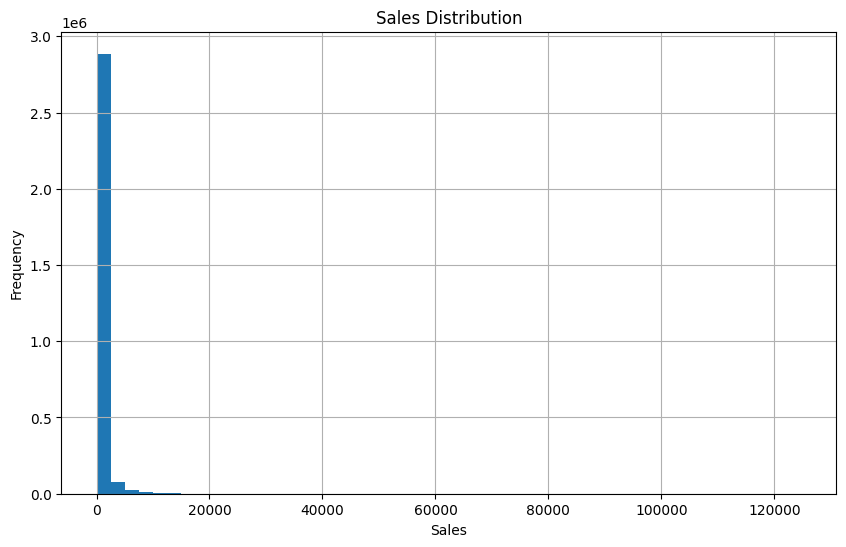

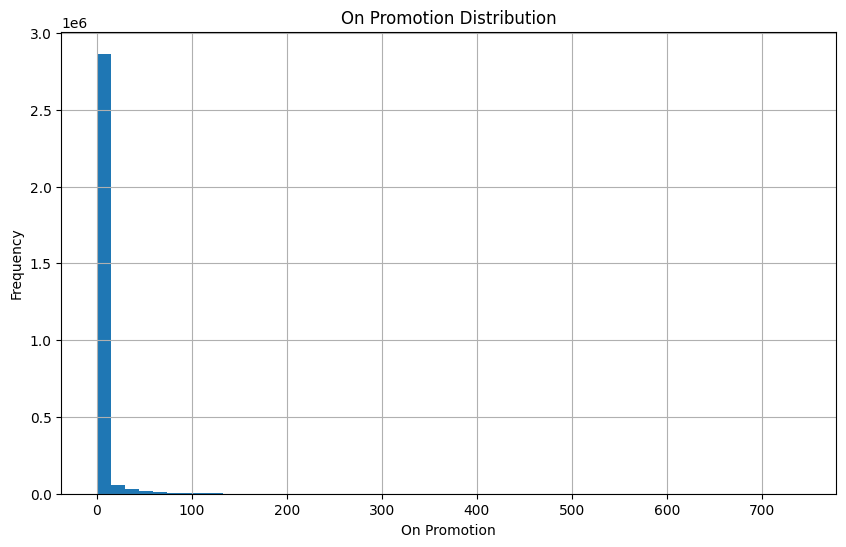

In [53]:
#Histogram for 'sales'
plt.figure(figsize=(10, 6)) 
train_data['sales'].hist(bins=50)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

#Histogram for 'onpromotion'
plt.figure(figsize=(10, 6))
train_data['onpromotion'].hist(bins=50)
plt.title('On Promotion Distribution')
plt.xlabel('On Promotion')
plt.ylabel('Frequency')
plt.show()


Observations;
* The majority of the sales values are concentrated near zero, indicating that either many items did not sell or had very low sales.
* The histogram is right-skewed, with a long tail extending towards higher sales values. This indicates that while most sales are low, there are some occurrences of significantly higher sales values. These outliers are much less frequent.
* Similar to the sales histogram, the majority of the onpromotion values are concentrated at the lower end, particularly near zero. A large number of records have zero or very few items on promotion.
* The histogram is right-skewed, with a long tail extending towards higher values. While most records have low values for onpromotion, there are some instances where a significantly higher number of items are on promotion. These higher values are less frequent but present.

Box Plots to identify the Spread and Outliers in the Sales and Onpromotion Columns.

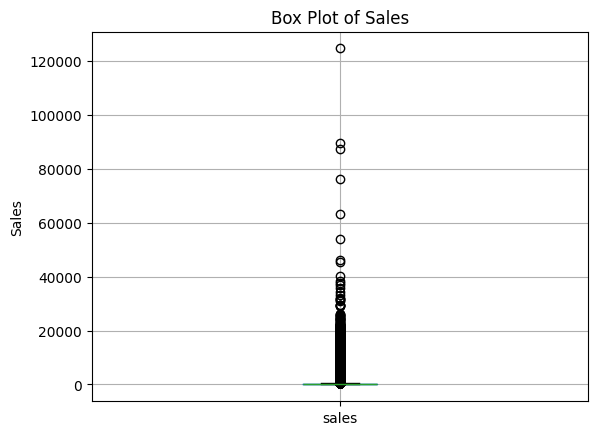

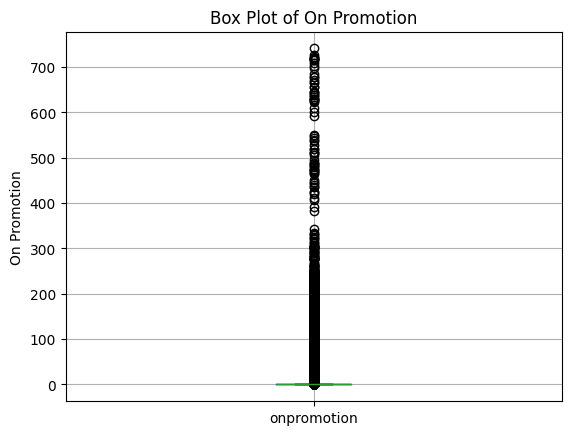

In [54]:
#Box plot for 'sales'
train_data.boxplot(column='sales')
plt.title('Box Plot of Sales')
plt.ylabel('Sales')
plt.show()

#Box plot for 'onpromotion'
train_data.boxplot(column='onpromotion')
plt.title('Box Plot of On Promotion')
plt.ylabel('On Promotion')
plt.show()

Observations;
* The majority of the sales data points are concentrated at the lower end, with a small range of typical sales values as indicated by the box.
* The high number of outliers shows that there are instances with very high sales, suggesting rare but significant peaks in sales.
* Majority of the data points for "onpromotion" are clustered around the lower values, with a few stores having exceptionally high promotional activity.

#### Analysing the Trend of Sales Over Time

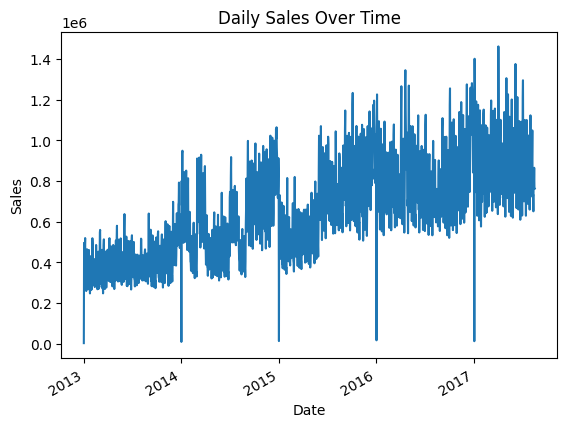

In [55]:
#Group by date and sum sales
daily_sales = train_data.groupby('date')['sales'].sum()

#Time series plot of daily sales
daily_sales.plot()
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Observations;
* Sales are progressively increasing from 2013 to 2017.
* There are regular peaks and troughs throughout each year. This suggests seasonality, where certain times of the year consistently show higher sales.
* Notable dips to near zero occur at regular intervals, likely representing specific events such as holidays when stores might be closed, or regular patterns of very low sales days.

#### Bivariate Analysis

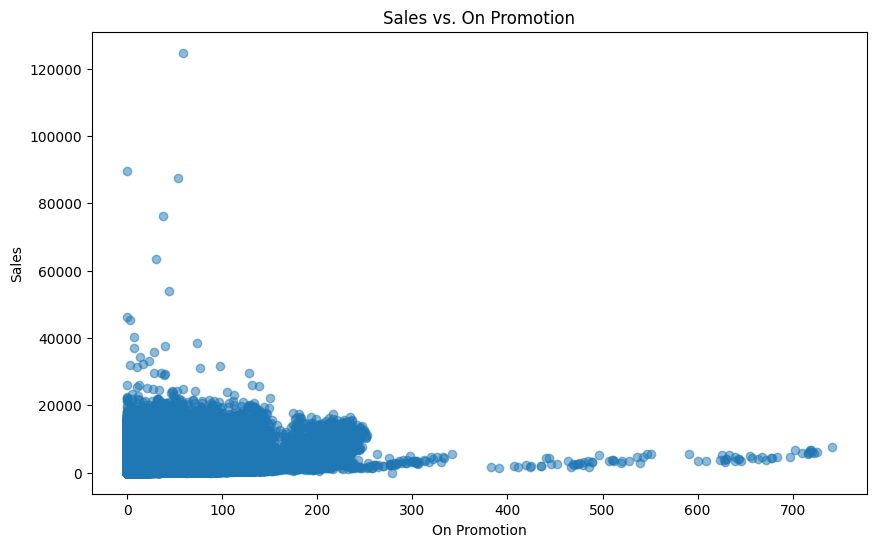

In [56]:
#Scatter plot between sales and onpromotion
plt.figure(figsize=(10, 6))
plt.scatter(train_data['onpromotion'], train_data['sales'], alpha=0.5)
plt.title('Sales vs. On Promotion')
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.show()

Observations;
* The majority of data points are clustered at the lower end of the 'On Promotion' axis, with most of the sales occurring when the number of items on promotion is low.
* There is a high density of points at the lower left corner, indicating that for most dates or data entries, a relatively small number of items are on promotion.

### Multivariate Analysis

### Data Preparation

We have already noticed there are no missing values in the all datasets  except oil_data (43 null) from the EDA made above

In [57]:
oil_data.isna().sum()

Unnamed: 0     0
dcoilwtico    43
dtype: int64

In [58]:
#Check the statistical values in the oil data
oil_data.describe()

,Unnamed: 0,dcoilwtico
count,1218.000000,1175.000000
mean,608.500000,67.714366
std,351.750622,25.630476
min,0.000000,26.190001
25%,304.250000,46.405001
50%,608.500000,53.189999
75%,912.750000,95.660000
max,1217.000000,110.620003


In [59]:
oil_data['dcoilwtico']

date
2013-01-01          NaN
2013-01-02    93.139999
2013-01-03    92.970001
2013-01-04    93.120003
2013-01-07    93.199997
                ...    
2017-08-25    47.650002
2017-08-28    46.400002
2017-08-29    46.459999
2017-08-30    45.959999
2017-08-31    47.259998
Name: dcoilwtico, Length: 1218, dtype: float64

In [60]:
#Replace nan value with np.nan
oil_data.replace('nan', np.nan, inplace=True)

#Fill null values with forward fill
oil_data = oil_data.fillna(method = 'ffill')

In [61]:
oil_data.isna().sum()

Unnamed: 0    0
dcoilwtico    1
dtype: int64

In [62]:
oil_data.head(7)

,Unnamed: 0,dcoilwtico
date,,
2013-01-01,0,NaN
2013-01-02,1,93.139999
2013-01-03,2,92.970001
2013-01-04,3,93.120003
2013-01-07,4,93.199997
2013-01-08,5,93.209999
2013-01-09,6,93.080002


In [63]:
#Single missing value is at the start of the dataframe so fill with backward fill 
oil_data = oil_data.fillna(method = 'bfill')

In [64]:
# confirm missing value filled
oil_data.isna().sum()

Unnamed: 0    0
dcoilwtico    0
dtype: int64

In [65]:
oil_data.head(7)

,Unnamed: 0,dcoilwtico
date,,
2013-01-01,0,93.139999
2013-01-02,1,93.139999
2013-01-03,2,92.970001
2013-01-04,3,93.120003
2013-01-07,4,93.199997
2013-01-08,5,93.209999
2013-01-09,6,93.080002


In [66]:
#Drop the unnamed column
oil_data.drop(columns=['Unnamed: 0'], inplace=True)

In [67]:
oil_data.head(7)

,dcoilwtico
date,
2013-01-01,93.139999
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997
2013-01-08,93.209999
2013-01-09,93.080002


In [68]:
test_data.head(7)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
5,3000893,2017-08-16,1,BREAD/BAKERY,12
6,3000894,2017-08-16,1,CELEBRATION,0


In [69]:
#Make date the index the test data
test_data.set_index('date', inplace=True)

In [70]:
test_data.head(7)

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0
2017-08-16,3000893,1,BREAD/BAKERY,12
2017-08-16,3000894,1,CELEBRATION,0


Decomp

In [72]:
train_data.head(7)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0


In [73]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


Checking Stationarity in Dataset


In [74]:
#  'date' is your datetime column
train_data['date'] = pd.to_datetime(train_data['date'])

# Setting the datetime column as the index
train_data.set_index('date', inplace=True)

In [77]:
#Downsampling the dataset to monthly frequency to check for stationarity
df_monthly = train_data['sales'].resample('M').mean()

#Applying the ADF test to the downsampled dataset
result = adfuller(df_monthly.dropna())

#Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result [1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -1.574663931940097
p-value: 0.4963069089455667
Data is not stationary


In [78]:
#Downsampling the dataset to weekly frequency to check for stationarity
df_weekly = train_data['sales'].resample('W').mean()

#Applying the ADF test to the downsampled dataset
result = adfuller(df_weekly.dropna())

#Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result [1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -1.5903747027604562
p-value: 0.48842681062681376
Data is not stationary


In [79]:
#Downsampling the dataset to daily frequency to check for stationarity
df_daily = train_data['sales'].resample('D').mean()

# Applying the ADF test to the downsampled dataset
result = adfuller(df_daily.dropna())

# Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result [1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -2.6161957486048673
p-value: 0.08969592175787261
Data is not stationary


Using Rolling Statistiocs to visualize Stationarity

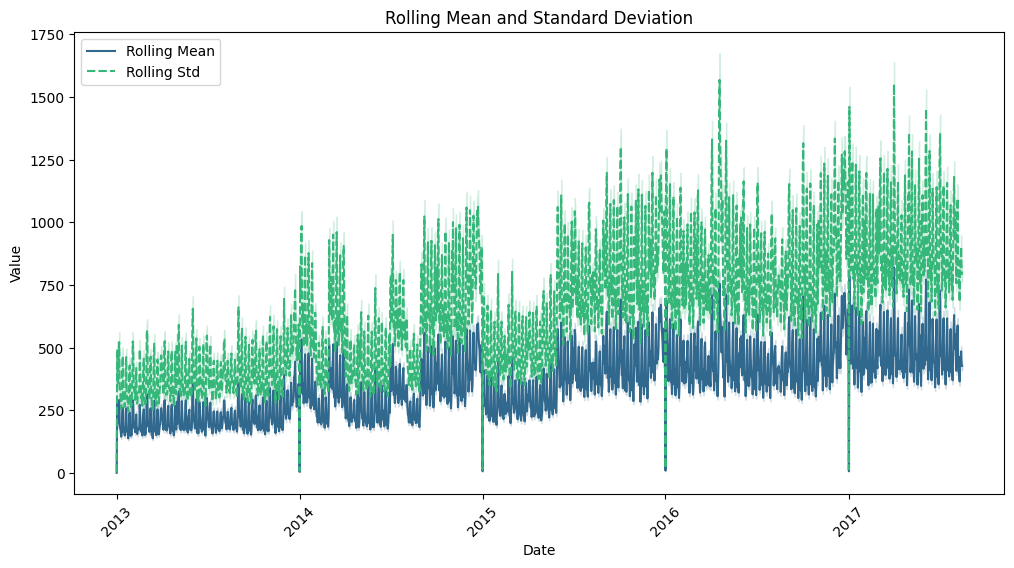

In [80]:
rolling_mean = train_data["sales"].rolling(window=7).mean()
rolling_std = train_data["sales"].rolling(window=7).std()

#Create a new DataFrame for the rolling statistics
rolling_stats = pd.DataFrame({'Rolling Mean': rolling_mean, 'Rolling Std': rolling_std})

#Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=rolling_stats, palette="viridis")
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

#### Hypothesis Testing
Null Hypothesis (H0): Promotional activities do not have a significant impact on sales



Alternate Hypothesis (H1): Promotional activities have a significant impact on sales

In [81]:
#Split Promoted items and those that were not promoted
train_data['onpromotion_encoded'] = np.where(train_data['onpromotion'] >= 1, 1, 0)
train_data['onpromotion_encoded'].value_counts()

onpromotion_encoded
0    2389559
1     611329
Name: count, dtype: int64

In [86]:
# Extract the relevant variables for the hypothesis test
sales_on_promotion = train_data[train_data['onpromotion_encoded'] == 1]['sales']
sales_not_on_promotion = train_data[train_data['onpromotion_encoded'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(sales_on_promotion, sales_not_on_promotion) 

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): Promotional activities do not have a significant impact on sales.")
print("Alternative Hypothesis (H1): Promotional activities have a significant impact on sales.")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print(" We reject the null hypothesis.")
    print("Promotional activities have a significant impact on sales at Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis.")
    print("Promotional activities do not have a significant impact on sales at Corporation Favorita.")      
          

Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): Promotional activities do not have a significant impact on sales.
Alternative Hypothesis (H1): Promotional activities have a significant impact on sales.
--------------------------------------------------
Test Statistic: 664.1236909096903
P-value: 0.0
 We reject the null hypothesis.
Promotional activities have a significant impact on sales at Corporation Favorita.
